In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets
from torchvision import transforms

/home/juxiaobing/anaconda3/envs/pocket/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br>

## Define Teacher and Student Network

<br>

## Prepare Dataset

In [ ]:
transform = transforms.Compose([transforms.Grayscale(3), # Match the mnist channel dim with vgg19 input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

mnist = datasets.MNIST(root='/home/juxiaobing/code/GraduationProject/Novelty_Detection/mnist/MNIST/raw', 
                       train=True, 
                       download=True,
                       transform=transform)

train_loader = DataLoader(dataset=mnist,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

<br>

## Train Student Network

In [2]:
import torch
import torch.nn.functional as F
import glob
import os
from collections import OrderedDict
from sortedcontainers import SortedDict, SortedSet
import cv2
import numpy as np
import tqdm
from rich.progress import track
from rich import print


class TrajectoryDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_dir="/home/juxiaobing/code/GraduationProject/CNN-VAE/data/T15/T15_images_test", labels: SortedSet = {1, 2}):

        self.extract_labels = labels
        self.dataset_dir = dataset_dir
        self.length = 0
        self.img_labels_ = self.get_labels()
        self.img_dicts = {}
        self.read_imgs()

    def get_labels(self):
        class_dirs = os.path.join(self.dataset_dir, '*')
        paths = glob.glob(class_dirs)
        labels = []
        for path in paths:
            label = (int)(path.split('/')[-1])
            if label in self.extract_labels:
                img_paths = glob.glob(os.path.join(path, '*.jpg'))
                for img_path in img_paths:
                    labels.append([img_path, label])
                self.length += len(img_paths)
        return labels

    def read_imgs(self):
        for idx in track(range(self.length), description="Load Images:"):
            self.img_dicts[idx] = self.read_img(self.img_labels_[idx][0])

    def read_img(self, img_path, need_trasform=True):

        cvimg = cv2.imread(img_path)

        if need_trasform:
            cvimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)

        # cvimg = cv2.resize(cvimg, (64, 64))

        # cvimg = cv2.normalize(cvimg, 0, 1, norm_type=cv2.NORM_MINMAX)

        cvimg = np.transpose(np.array(cvimg, np.float32), [2, 0, 1])

        return cvimg

    def __len__(self):
        return self.length

    def __getitem__(self, idx: int):
        if idx not in self.img_dicts:
            self.img_dicts[idx] = self.read_img(self.img_labels_[idx][0])
        return self.img_dicts[idx], self.img_labels_[idx][1]



In [4]:
train_dataset = TrajectoryDataset(labels={1,2})

In [7]:
BATCH_SIZE = 8

train_dataset = TrajectoryDataset(labels={1,2,3,4})

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

DEVICE = 'cuda:0'
EPOCHS = 1000
BASEBONE = "resnet101"

model_path = os.path.join(os.getcwd(),"models")

if not os.path.exists(model_path):
    os.mkdir(model_path)

student_net_path = os.path.join(model_path,"stu_net.pth")
teacher_net_path = os.path.join(model_path,"tea_net.pth")


if os.path.exists(student_net_path):
    student = torch.load(student_net_path)
    print("stu load from ",student_net_path)
else:
    restnet = models.resnet101(pretrained=False)
    student = restnet.to(DEVICE)
    
if os.path.exists(teacher_net_path):
    teacher = torch.load(teacher_net_path)
else:    
    pretrained_resnet = models.resnet101(pretrained=True)
    # teacher = pretr16

teacher.eval()

if os.path.exists(student_net_path):
    student = torch.load(student_net_path)
    print("stu load from ",student_net_path)


criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

for epoch in range(EPOCHS):
    total_loss = 0
    total_iters = 0
    for data in train_loader:
        total_iters = total_iters + 1
        img = data[0].to(DEVICE)
        with torch.no_grad():
            surrogate_label = teacher(img)
        optimizer.zero_grad()
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
    print("Epoch:%d"%(epoch),"aveloss:",(total_loss / total_iters),end='\r')
    torch.save(teacher,teacher_net_path)
    torch.save(student,student_net_path)
    

Load images .... 


100%|██████████| 606/606 [00:00<00:00, 735.11it/s]


<br>

## Measure Anomaly Score

In [14]:
valid_dataset = TrajectoryDataset(dataset_dir="/home/juxiaobing/code/GraduationProject/CNN-VAE/data/T15/T15_images",labels={1,2,3,4,5,6,7,8,9,10,11,12,13,14,15})

valid_loader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

/home/juxiaobing/anaconda3/envs/pocket/lib/python3.8/site-packages/rich/live.py:221: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [15]:
teacher = torch.load("/home/juxiaobing/code/GraduationProject/STAD/models/resnet101/t_net.pth")
student = torch.load("/home/juxiaobing/code/GraduationProject/STAD/models/resnet101/s_net.pth")

DEVICE = "cuda:0"

teacher.to(DEVICE)
student.to(DEVICE)

criterion = torch.nn.MSELoss(reduction='mean')

teacher.eval()
student.eval()

losses = []
digits = []
for img, digit in tqdm.tqdm(valid_loader):
    with torch.no_grad():
        img = img.to(DEVICE)
        surrogate_label = teacher(img)
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        losses.append(loss.item())
        digits.append(digit)

100%|██████████| 1329/1329 [00:39<00:00, 33.78it/s]


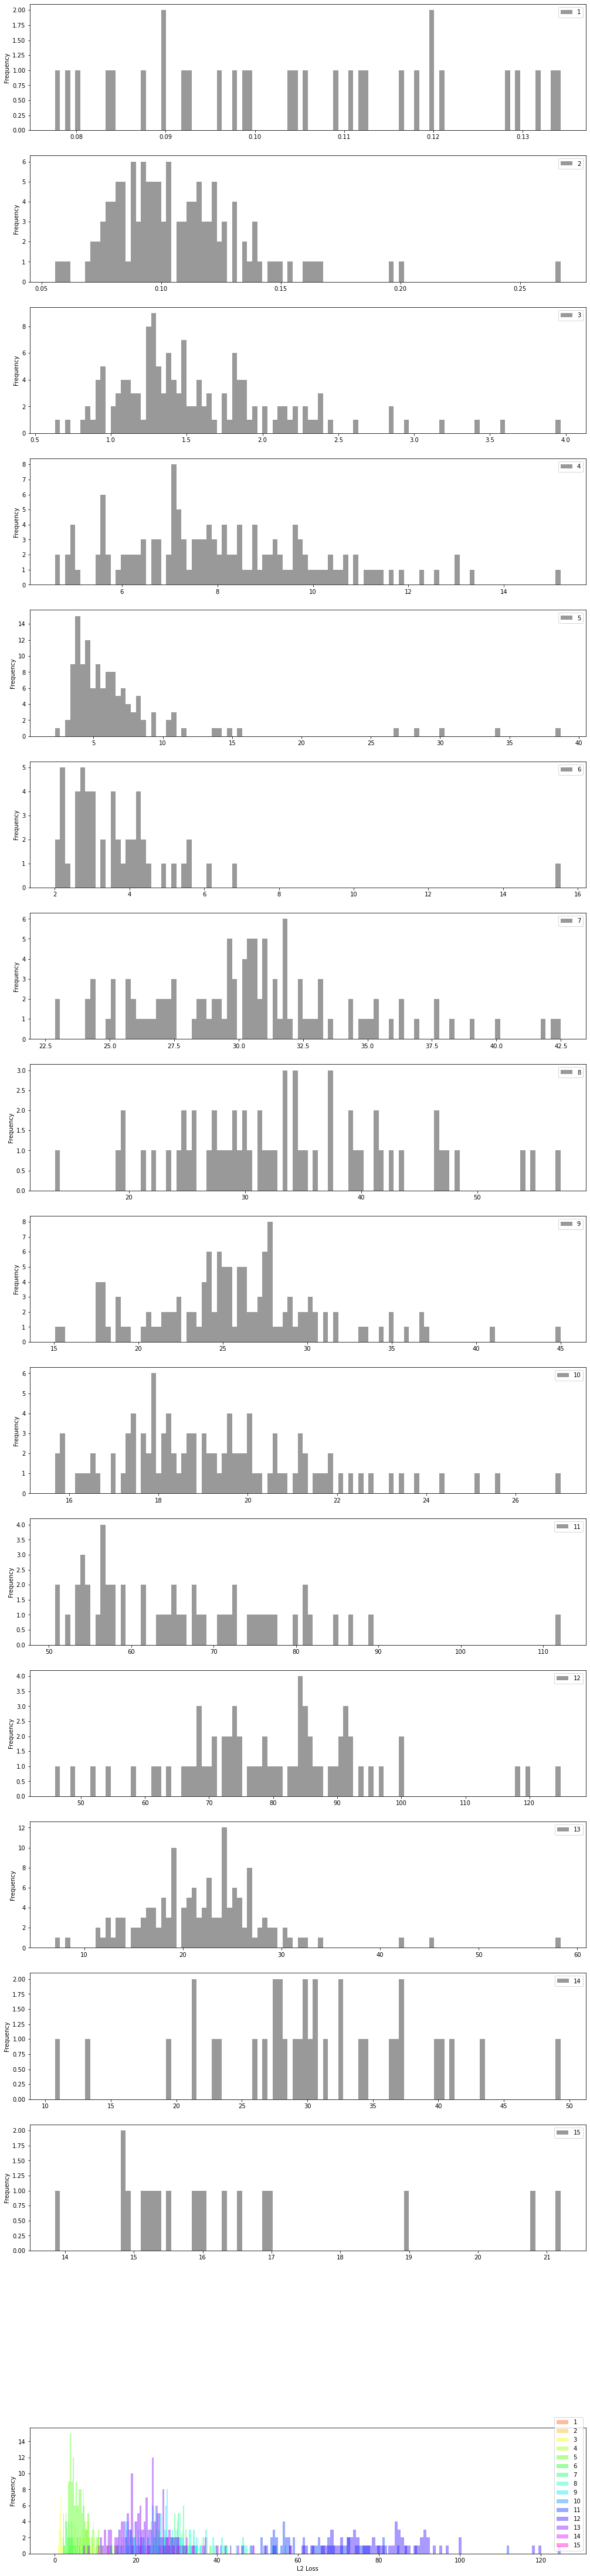

{
    1: [0.07759877294301987, 0.13427282869815826],
    2: [0.055617500096559525, 0.26696452498435974],
    3: [0.6311964988708496, 3.9668002128601074],
    4: [4.601086139678955, 15.18648910522461],
    5: [2.2208657264709473, 38.699684143066406],
    6: [2.005997657775879, 15.542563438415527],
    7: [22.877038955688477, 42.49565124511719],
    8: [13.624480247497559, 57.19195556640625],
    9: [15.065691947937012, 45.01346206665039],
    10: [15.676518440246582, 27.017915725708008],
    11: [50.75459671020508, 112.12580108642578],
    12: [45.95637893676758, 124.8680419921875],
    13: [7.029434680938721, 58.32228469848633],
    14: [10.73434066772461, 49.33994674682617],
    15: [13.853805541992188, 21.203594207763672]
}

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

losses = np.array(losses)
digits = np.array(digits)

loss_dict = {}


plt.figure(figsize=(17, 80))
for i in range(1,16):
    plt.subplot(17,1,i)
    cur_losses = losses[digits==i];
    plt.hist(cur_losses, label=str(i), bins=100, color='k', alpha=0.4)
    plt.legend()
    plt.ylabel('Frequency')
    loss_dict[i] = [np.min(cur_losses),np.max(cur_losses)]
    plt.subplot(17, 1, 17)
    color = cm.hsv(i/17)
    plt.hist(losses[digits==i], label=str(i), bins=100, color=color, alpha=0.4)

plt.legend()
plt.xlabel('L2 Loss')
plt.ylabel('Frequency')
plt.show()

print(loss_dict)
